<a href="https://colab.research.google.com/github/ChrizZhuang/memtransistor_NLP/blob/main/RNN_4_terminals_memtransistor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RNN Simulation of Dual gates 4 terminals memtransistor**

**Hardware paper**

- *Dual-Gated MoS2 Memtransistor Crossbar Array* https://onlinelibrary.wiley.com/doi/abs/10.1002/adfm.202003683

**Hardware code with the application of CV**

- https://colab.research.google.com/drive/1_zY4qp1u8IZhc_ht4t-iHr2m53j7u2li

**RNN Algorithm for sentiment analysis**

- https://www.tensorflow.org/text/tutorials/text_classification_rnn

### **Import modules**

In [ ]:
# uses tensorflow v2.7.0
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

tfds.disable_progress_bar()
print(tf.__version__)

2.7.0


In [ ]:
# mount to google drive to save model and weights
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Utils**


In [ ]:
# imports data from single column CSV file with possible current/conductance states
# return numpy array of approximate states possible using this hardware
# this import method is not generalized, but fine-tuned to Vinod's devices
def import_data_from_csv(filename):
  # import data
  imported_device_states = np.genfromtxt(filename, delimiter=',')[1:]

  # since data is in ~1 nA, assume maximum precision is ~1 pA
  # this will make some states redundant
  imported_device_states = np.unique(np.round(np.sort(imported_device_states), decimals=3))

  # calculate device states possible
  device_states = np.array([])
  for i, value in enumerate(imported_device_states):
      if i+1 > len(imported_device_states):
          break
      temp_ls = value - imported_device_states
      device_states = np.append(device_states, temp_ls)


  # normalize to -1 to 1
  device_states = np.unique(np.sort(device_states))
  device_states = device_states / np.abs(device_states).max()

  # given the large number of states, we can assume some states are almost equivalent
  # moreover, once the number of states is > 100, the discreteness doesnt matter
  # for simplicity in the simulations, we will simply  round to 2 digits of the calculated states
  device_states = np.round(device_states, decimals = 2)
  device_states = np.unique(np.sort(device_states))
  
  return device_states

In [ ]:
def plot_figure(train_accuracy, test_accuracy):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(len(train_accuracy)), train_accuracy, label = 'train')
  plt.plot(np.arange(len(test_accuracy)), test_accuracy, label = 'test')
  plt.legend(fontsize=15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel("epoch", fontsize=15)
  plt.ylabel("accuracy", fontsize=15)
  plt.show()

###**Construct the final function**

In [ ]:
def run_RNN_simulation(save_results_input=False,
            num_epochs_input=50, 
            hardware_simulation_input=False, 
            device_states_input=False,
            read_noise_mean_input=0,
            read_noise_stddev_input=0,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True):
  
  ###################### USER DEFINED PARAMETERS FOR SIMULATION
  # whether or not to save results
  SAVE_RESULTS = save_results_input
  
  # number of epochs to test
  NUM_EPOCHS = num_epochs_input

  # flag which determines whether this is a hardware simulation or purely software
  HARDWARE_SIMULATION = hardware_simulation_input

  # parameter set by user that gives all the possible normalized weight states
  DEVICE_STATES = device_states_input

  # parameters for simulating read noise
  # user input = read noise mean and standard dev assuming a normal noise function
  READ_NOISE_MEAN = read_noise_mean_input
  READ_NOISE_STDDEV = read_noise_stddev_input

  # parameter for simulating device-to-device variation
  # user input =  standard deviation of conductances
  DEVICE_VARIATION_STDDEV = device_variation_stddev_input

  # parameter for simulating devices that get stuck on Gmax or Gmin states from the start
  # user input = probability for a device to get stuck
  DEVICE_STUCK_ON_PROB = device_stuck_on_prob_input
  DEVICE_STUCK_OFF_PROB = device_stuck_off_prob_input

  # for RNN model and training
  BUFFER_SIZE = 10000
  BATCH_SIZE = 32

  # load data
  dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
  train_dataset, test_dataset = dataset['train'], dataset['test']

  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  VOCAB_SIZE = 1000
  # Maximum size of the vocabulary for this layer. 
  # This should only be specified when adapting a vocabulary or when setting pad_to_max_tokens=True. 
  encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, name = 'encoder')
  # adapt: Fits the state of the preprocessing layer to the data being passed.
  encoder.adapt(train_dataset.map(lambda text, label: text))

  vocab = np.array(encoder.get_vocabulary()) 

  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        name='embedding',
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32, name='lstm'),
    tf.keras.layers.Dense(32, activation='relu', name='dense1'),
    tf.keras.layers.Dense(1, name='dense2')
  ])

  plot_time = time.time()
  plot_dir = '/content/drive/MyDrive/RNN_model_plot/'+str(plot_time)+'model.png'
  tf.keras.utils.plot_model(model, to_file=plot_dir, show_shapes=True, show_layer_names=True)

  # 1. keras.layers.preprocessing.index_lookup.VocabWeightHandler - not trainable
  # 2. 'embedding/embeddings:0' shape=(1000, 32)
  # 3. 'lstm/lstm_cell/kernel:0' shape=(32, 256)
  # 4. 'lstm/lstm_cell/recurrent_kernel:0' shape=(32, 256)
  # 5. 'lstm/lstm_cell/bias:0' shape=(256,)
  # 6. 'dense/kernel:0' shape=(32, 32)
  # 7. 'dense/bias:0' shape=(32,)
  # 8. 'dense_1/kernel:0' shape=(32, 1)
  # 9. 'dense_1/bias:0' shape=(1,)
  model_weights = model.trainable_variables # len(weights) = 8

  g_min_value = np.min(np.abs(DEVICE_STATES))
  g_max_value = np.max(np.abs(DEVICE_STATES))
      
  # to make this notebook's output stable across runs
  def reset_graph(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

  # create matrix to simulate device-to-device variation by creating clipping the weights
  # and simulate devices being stuck-on-open and stuck-on-close 
  def initialize_variation_stuck_mat(shape):
    # VARIATION
    wp_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wp_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    wm_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wm_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    # STUCK
    stuck_prob = [DEVICE_STUCK_OFF_PROB, 1 - DEVICE_STUCK_ON_PROB - DEVICE_STUCK_OFF_PROB, DEVICE_STUCK_ON_PROB]
    w_p_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob) 
    w_m_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)

    # if device is stuck OFF
    wp_max = wp_max + (w_p_stuck == -1) * (wp_min - wp_max)
    wm_max = wm_max + (w_m_stuck == -1) * (wm_min - wm_max)

    # if device is stuck ON
    wp_min = wp_min + (w_p_stuck == 1) * (wp_max - wp_min)
    wm_min = wm_min + (w_m_stuck == 1) * (wm_max - wm_min)


    # PUTTING TOGETHER CLIPPING MATRIX
    # numpy.clip(a, a_min, a_max) 
    # Clip (limit) the values in an array.
    # Given an interval, values outside the interval are clipped to the interval edges
    lower_lim = np.clip(wp_min - wm_max, -g_max_value, -g_min_value)
    upper_lim = np.clip(wp_max - wm_min, g_min_value, g_max_value)

    #print('Lower lim: ' + str(lower_lim))
    #print('Upper lim: ' + str(upper_lim))

    return [lower_lim, upper_lim]

  # weight update with a discrete number of states and (optional) add read noise
  def discrete_weight_update(value, read_noise_mean=0, read_noise_stddev=0):
      if read_noise_stddev != 0:
          value += np.random.normal(read_noise_mean, read_noise_stddev)
      absolute_difference_function = lambda list_value : abs(list_value - value)
      return min(DEVICE_STATES, key=absolute_difference_function)
  v_discrete_weight_update = np.vectorize(discrete_weight_update)

  # function puts together all the parts
  # 1. Device variation
  # 2. Stuck-on/off 
  # 3. Discrete number of weight states
  # Input = software weights matrix, Output = hardware weights matrix
  def simulate_hardware_weight_update(weights_mat, var_stuck_mat):

    # initialize variation and stuck matrix if not initialized
    if type(weights_mat) is not np.array:
      weights_mat = np.array(weights_mat)

    if type(var_stuck_mat) is not np.ndarray:
        var_stuck_mat = initialize_variation_stuck_mat(weights_mat.shape)

    # simulate weight variation and stuck on open/close
    weights_mat = weights_mat.clip(var_stuck_mat[0], var_stuck_mat[1])

    # simulate discrete states
    weights_mat = v_discrete_weight_update(weights_mat, read_noise_mean = READ_NOISE_MEAN,
                          read_noise_stddev = READ_NOISE_STDDEV)

    return weights_mat

  # reset default tf graph before running sim
  reset_graph()

  # define weight update ops
  var_stuck_mat = [False, False, False, False, False, False, False, False]
  weights = np.zeros([1, 8])[0].tolist()
  new_weights = np.zeros([1, 8])[0].tolist()
  weight_update_op = np.zeros([1, 8])[0].tolist()
  weight_layers = ["embedding/embeddings:0", "lstm/lstm_cell/kernel:0", "lstm/lstm_cell/recurrent_kernel:0", "lstm/lstm_cell/bias:0",
            "dense1/kernel:0", "dense1/bias:0", "dense2/kernel:0", "dense2/bias:0"]

  train_accuracy_ls = []
  train_loss_ls = []

  test_accuracy_ls = []
  test_loss_ls = []

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

  # train the model weights
  for i in range(NUM_EPOCHS):
    # mark the time
    start_time = time.time()
    start_datetime  = datetime.utcnow().strftime("%Y%m%d%H%M%S")

    print("Training the "+str(i+1)+"th epoch!")

    history = model.fit(train_dataset, epochs=1,
            validation_data=test_dataset,
            validation_steps=30)
    
    train_accuracy_ls.append(history.history['accuracy'][0])
    train_loss_ls.append(history.history['loss'][0])
    test_accuracy_ls.append(history.history['val_accuracy'][0])
    test_loss_ls.append(history.history['val_loss'][0])

    if HARDWARE_SIMULATION:

      # obtain the original weights
      weights = model.trainable_variables

      # update the weights cosidering the hardware
      new_weights = []
      for i, weight in enumerate(weights):
        new_weights.append(simulate_hardware_weight_update(weight, var_stuck_mat[i]))

      model.layers[1].set_weights([new_weights[0]])
      model.layers[2].set_weights([new_weights[1], new_weights[2], new_weights[3]])
      model.layers[3].set_weights([new_weights[4], new_weights[5]])
      model.layers[4].set_weights([new_weights[6], new_weights[7]])

    # save the results for current epoch
    if SAVE_RESULTS:
      file_name = 'model_' + str(start_datetime) + '_' + str(NUM_EPOCHS)
      model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/'+file_name)
      print("Save results in file "+file_name+" successfully!\n")

  # save the final result
  if SAVE_RESULTS:
    file_name = 'final_model_' + '_' + str(NUM_EPOCHS)
    model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/'+file_name)
    print("Save results in file "+file_name+" successfully!\n")

  if plot_fig:
    plot_figure(train_accuracy_ls, test_accuracy_ls)

  return model, train_accuracy_ls, test_accuracy_ls

Training the 1th epoch!
782/782 [==============================] - 99s 119ms/step - loss: 0.6673 - accuracy: 0.5346 - val_loss: 0.5612 - val_accuracy: 0.6875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001347_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001347_30/assets


Save results in file model_20220213001347_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.4527 - accuracy: 0.7830 - val_loss: 0.4082 - val_accuracy: 0.8354


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001543_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001543_30/assets


Save results in file model_20220213001543_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3619 - accuracy: 0.8432 - val_loss: 0.3664 - val_accuracy: 0.8406


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001822_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213001822_30/assets


Save results in file model_20220213001822_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3389 - accuracy: 0.8553 - val_loss: 0.3585 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002102_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002102_30/assets


Save results in file model_20220213002102_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3248 - accuracy: 0.8621 - val_loss: 0.3650 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002249_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002249_30/assets


Save results in file model_20220213002249_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3244 - accuracy: 0.8624 - val_loss: 0.3512 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002438_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002438_30/assets


Save results in file model_20220213002438_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3128 - accuracy: 0.8666 - val_loss: 0.3402 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002717_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002717_30/assets


Save results in file model_20220213002717_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3139 - accuracy: 0.8673 - val_loss: 0.3486 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002904_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213002904_30/assets


Save results in file model_20220213002904_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3082 - accuracy: 0.8680 - val_loss: 0.3496 - val_accuracy: 0.8365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003144_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003144_30/assets


Save results in file model_20220213003144_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3086 - accuracy: 0.8689 - val_loss: 0.3421 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003423_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003423_30/assets


Save results in file model_20220213003423_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3038 - accuracy: 0.8710 - val_loss: 0.3384 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003611_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003611_30/assets


Save results in file model_20220213003611_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3079 - accuracy: 0.8700 - val_loss: 0.3378 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003850_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213003850_30/assets


Save results in file model_20220213003850_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3030 - accuracy: 0.8729 - val_loss: 0.3337 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004038_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004038_30/assets


Save results in file model_20220213004038_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3008 - accuracy: 0.8717 - val_loss: 0.3404 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004318_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004318_30/assets


Save results in file model_20220213004318_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2974 - accuracy: 0.8722 - val_loss: 0.3332 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004557_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004557_30/assets


Save results in file model_20220213004557_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2970 - accuracy: 0.8718 - val_loss: 0.3357 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004836_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213004836_30/assets


Save results in file model_20220213004836_30 successfully!

Training the 17th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2947 - accuracy: 0.8744 - val_loss: 0.3333 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005115_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005115_30/assets


Save results in file model_20220213005115_30 successfully!

Training the 18th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2969 - accuracy: 0.8733 - val_loss: 0.3528 - val_accuracy: 0.8365


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005303_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005303_30/assets


Save results in file model_20220213005303_30 successfully!

Training the 19th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2992 - accuracy: 0.8722 - val_loss: 0.3337 - val_accuracy: 0.8531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005542_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005542_30/assets


Save results in file model_20220213005542_30 successfully!

Training the 20th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2930 - accuracy: 0.8730 - val_loss: 0.3354 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005729_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213005729_30/assets


Save results in file model_20220213005729_30 successfully!

Training the 21th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2913 - accuracy: 0.8750 - val_loss: 0.3411 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010009_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010009_30/assets


Save results in file model_20220213010009_30 successfully!

Training the 22th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2892 - accuracy: 0.8761 - val_loss: 0.3361 - val_accuracy: 0.8479


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010248_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010248_30/assets


Save results in file model_20220213010248_30 successfully!

Training the 23th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2884 - accuracy: 0.8760 - val_loss: 0.3417 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010436_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010436_30/assets


Save results in file model_20220213010436_30 successfully!

Training the 24th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2874 - accuracy: 0.8764 - val_loss: 0.3356 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010623_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010623_30/assets


Save results in file model_20220213010623_30 successfully!

Training the 25th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2873 - accuracy: 0.8771 - val_loss: 0.3398 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010811_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213010811_30/assets


Save results in file model_20220213010811_30 successfully!

Training the 26th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2849 - accuracy: 0.8801 - val_loss: 0.3462 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011050_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011050_30/assets


Save results in file model_20220213011050_30 successfully!

Training the 27th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2857 - accuracy: 0.8779 - val_loss: 0.3405 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011238_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011238_30/assets


Save results in file model_20220213011238_30 successfully!

Training the 28th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2824 - accuracy: 0.8793 - val_loss: 0.3440 - val_accuracy: 0.8458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011516_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011516_30/assets


Save results in file model_20220213011516_30 successfully!

Training the 29th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2852 - accuracy: 0.8795 - val_loss: 0.3467 - val_accuracy: 0.8490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011756_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213011756_30/assets


Save results in file model_20220213011756_30 successfully!

Training the 30th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2822 - accuracy: 0.8801 - val_loss: 0.3693 - val_accuracy: 0.8615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012035_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012035_30/assets


Save results in file model_20220213012035_30 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


Save results in file final_model__30 successfully!



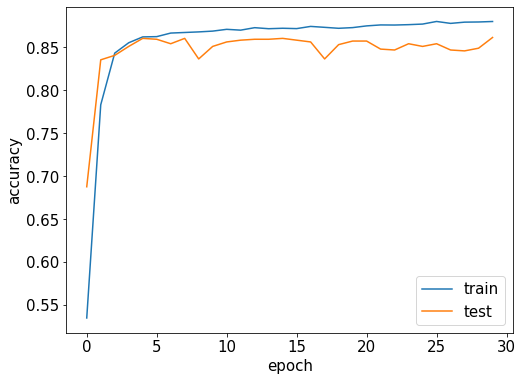

In [ ]:
# for the 1st learning curve from vinod
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_1.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

Training the 1th epoch!
782/782 [==============================] - 98s 117ms/step - loss: 0.6454 - accuracy: 0.5544 - val_loss: 0.5115 - val_accuracy: 0.7135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012242_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012242_30/assets


Save results in file model_20220213012242_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.4133 - accuracy: 0.8174 - val_loss: 0.3922 - val_accuracy: 0.8302


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012521_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012521_30/assets


Save results in file model_20220213012521_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3448 - accuracy: 0.8526 - val_loss: 0.3710 - val_accuracy: 0.8323


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012704_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012704_30/assets


Save results in file model_20220213012704_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3238 - accuracy: 0.8634 - val_loss: 0.3497 - val_accuracy: 0.8490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012847_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213012847_30/assets


Save results in file model_20220213012847_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3152 - accuracy: 0.8682 - val_loss: 0.3479 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013030_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013030_30/assets


Save results in file model_20220213013030_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3110 - accuracy: 0.8704 - val_loss: 0.3409 - val_accuracy: 0.8458


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013213_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013213_30/assets


Save results in file model_20220213013213_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3072 - accuracy: 0.8721 - val_loss: 0.3574 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013355_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013355_30/assets


Save results in file model_20220213013355_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.3065 - accuracy: 0.8722 - val_loss: 0.3459 - val_accuracy: 0.8521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013539_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013539_30/assets


Save results in file model_20220213013539_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3046 - accuracy: 0.8723 - val_loss: 0.3378 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013813_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013813_30/assets


Save results in file model_20220213013813_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3022 - accuracy: 0.8738 - val_loss: 0.3456 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013957_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213013957_30/assets


Save results in file model_20220213013957_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3020 - accuracy: 0.8744 - val_loss: 0.3372 - val_accuracy: 0.8531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014140_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014140_30/assets


Save results in file model_20220213014140_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.3020 - accuracy: 0.8724 - val_loss: 0.3436 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014415_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014415_30/assets


Save results in file model_20220213014415_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2999 - accuracy: 0.8754 - val_loss: 0.3384 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014649_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014649_30/assets


Save results in file model_20220213014649_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2992 - accuracy: 0.8742 - val_loss: 0.3357 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014924_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213014924_30/assets


Save results in file model_20220213014924_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2974 - accuracy: 0.8760 - val_loss: 0.3347 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015108_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015108_30/assets


Save results in file model_20220213015108_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2971 - accuracy: 0.8769 - val_loss: 0.3352 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015343_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015343_30/assets


Save results in file model_20220213015343_30 successfully!

Training the 17th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2956 - accuracy: 0.8776 - val_loss: 0.3317 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015617_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015617_30/assets


Save results in file model_20220213015617_30 successfully!

Training the 18th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2947 - accuracy: 0.8768 - val_loss: 0.3362 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015852_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213015852_30/assets


Save results in file model_20220213015852_30 successfully!

Training the 19th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2903 - accuracy: 0.8792 - val_loss: 0.3290 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020036_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020036_30/assets


Save results in file model_20220213020036_30 successfully!

Training the 20th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2907 - accuracy: 0.8780 - val_loss: 0.3284 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020220_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020220_30/assets


Save results in file model_20220213020220_30 successfully!

Training the 21th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2892 - accuracy: 0.8784 - val_loss: 0.3357 - val_accuracy: 0.8667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020403_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020403_30/assets


Save results in file model_20220213020403_30 successfully!

Training the 22th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2858 - accuracy: 0.8820 - val_loss: 0.3352 - val_accuracy: 0.8635


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020638_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020638_30/assets


Save results in file model_20220213020638_30 successfully!

Training the 23th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2833 - accuracy: 0.8813 - val_loss: 0.3321 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020822_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213020822_30/assets


Save results in file model_20220213020822_30 successfully!

Training the 24th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2822 - accuracy: 0.8821 - val_loss: 0.3424 - val_accuracy: 0.8667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021005_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021005_30/assets


Save results in file model_20220213021005_30 successfully!

Training the 25th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2793 - accuracy: 0.8841 - val_loss: 0.3286 - val_accuracy: 0.8667


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021240_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021240_30/assets


Save results in file model_20220213021240_30 successfully!

Training the 26th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.2791 - accuracy: 0.8846 - val_loss: 0.3414 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021424_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021424_30/assets


Save results in file model_20220213021424_30 successfully!

Training the 27th epoch!
782/782 [==============================] - 91s 115ms/step - loss: 0.2765 - accuracy: 0.8850 - val_loss: 0.3445 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021658_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021658_30/assets


Save results in file model_20220213021658_30 successfully!

Training the 28th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.2733 - accuracy: 0.8876 - val_loss: 0.3521 - val_accuracy: 0.8646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021933_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213021933_30/assets


Save results in file model_20220213021933_30 successfully!

Training the 29th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2721 - accuracy: 0.8873 - val_loss: 0.3433 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022117_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022117_30/assets


Save results in file model_20220213022117_30 successfully!

Training the 30th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.2708 - accuracy: 0.8878 - val_loss: 0.3493 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022300_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022300_30/assets


Save results in file model_20220213022300_30 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/final_model__30/assets


Save results in file final_model__30 successfully!



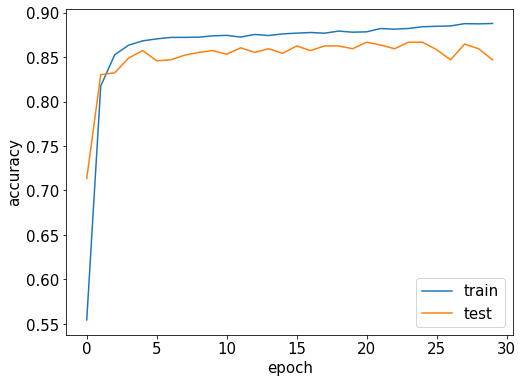

In [ ]:
# pure algorithm
model, train_accuracy_ls, test_accuracy_ls = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=False, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_2.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

Training the 1th epoch!
782/782 [==============================] - 97s 117ms/step - loss: 0.6430 - accuracy: 0.5616 - val_loss: 0.5110 - val_accuracy: 0.7073


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022503_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022503_30/assets


Save results in file model_20220213022503_30 successfully!

Training the 2th epoch!
782/782 [==============================] - 90s 114ms/step - loss: 0.4218 - accuracy: 0.8087 - val_loss: 0.3972 - val_accuracy: 0.8219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022657_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022657_30/assets


Save results in file model_20220213022657_30 successfully!

Training the 3th epoch!
782/782 [==============================] - 90s 115ms/step - loss: 0.3474 - accuracy: 0.8521 - val_loss: 0.3716 - val_accuracy: 0.8292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022936_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213022936_30/assets


Save results in file model_20220213022936_30 successfully!

Training the 4th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.3272 - accuracy: 0.8612 - val_loss: 0.3518 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023216_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023216_30/assets


Save results in file model_20220213023216_30 successfully!

Training the 5th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3184 - accuracy: 0.8668 - val_loss: 0.3493 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023405_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023405_30/assets


Save results in file model_20220213023405_30 successfully!

Training the 6th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3140 - accuracy: 0.8682 - val_loss: 0.3422 - val_accuracy: 0.8490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023555_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023555_30/assets


Save results in file model_20220213023555_30 successfully!

Training the 7th epoch!
782/782 [==============================] - 91s 116ms/step - loss: 0.3103 - accuracy: 0.8709 - val_loss: 0.3540 - val_accuracy: 0.8427


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023744_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213023744_30/assets


Save results in file model_20220213023744_30 successfully!

Training the 8th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3111 - accuracy: 0.8696 - val_loss: 0.3410 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024024_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024024_30/assets


Save results in file model_20220213024024_30 successfully!

Training the 9th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3092 - accuracy: 0.8697 - val_loss: 0.3386 - val_accuracy: 0.8531


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024303_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024303_30/assets


Save results in file model_20220213024303_30 successfully!

Training the 10th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3075 - accuracy: 0.8711 - val_loss: 0.3419 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024543_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024543_30/assets


Save results in file model_20220213024543_30 successfully!

Training the 11th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3077 - accuracy: 0.8702 - val_loss: 0.3352 - val_accuracy: 0.8500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024732_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213024732_30/assets


Save results in file model_20220213024732_30 successfully!

Training the 12th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3046 - accuracy: 0.8730 - val_loss: 0.3404 - val_accuracy: 0.8594


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025012_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025012_30/assets


Save results in file model_20220213025012_30 successfully!

Training the 13th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3058 - accuracy: 0.8710 - val_loss: 0.3372 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025251_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025251_30/assets


Save results in file model_20220213025251_30 successfully!

Training the 14th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3041 - accuracy: 0.8715 - val_loss: 0.3346 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025442_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025442_30/assets


Save results in file model_20220213025442_30 successfully!

Training the 15th epoch!
782/782 [==============================] - 93s 118ms/step - loss: 0.3017 - accuracy: 0.8731 - val_loss: 0.3369 - val_accuracy: 0.8542


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025632_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025632_30/assets


Save results in file model_20220213025632_30 successfully!

Training the 16th epoch!
782/782 [==============================] - 92s 117ms/step - loss: 0.3007 - accuracy: 0.8732 - val_loss: 0.3344 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025822_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts_final/model_20220213025822_30/assets


Save results in file model_20220213025822_30 successfully!

Training the 17th epoch!
109/782 [===>..........................] - ETA: 1:16 - loss: 0.3055 - accuracy: 0.8673

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_3.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learing_curves_csv/learning_curve_4.csv')
model, train_accuracy_ls_mem, test_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=30, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0,
            plot_fig=True)